In [1]:
import pylab as pl
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import scipy
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
import statsmodels.formula.api as smf
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from descartes import PolygonPatch
import urllib2
import json
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Prepare data

In [2]:
data0 = pd.read_csv('311_dead_animal.csv')
df = data0.dropna()
df['Created Date'] = pd.to_datetime(df['Created Date'])

/Users/Faye/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


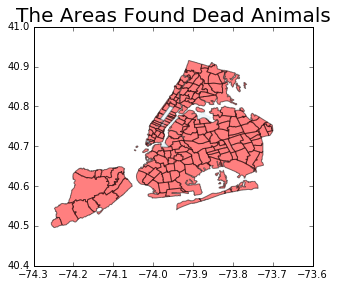

In [4]:
with open('nyc-zip-code-tabulation-areas-polygons.geojson') as data_file:    
    data = json.load(data_file)
    
nyc_zip = []
biz_zip = set()
for department in data['features']:
    nyc_zip.append(str(department['properties']["postalCode"]))
    
new_zip = set(df['Incident Zip'].astype(int).astype(str)).intersection(set(nyc_zip))
biz_zip = biz_zip.union(new_zip)

biz_zip = sorted(biz_zip)


fig = plt.figure(figsize=(5,5))
for i in data['features']:
    poly = i['geometry']
    postcode = str(i['properties']['postalCode'])
    ax = fig.gca()
    if postcode in list(biz_zip):
        ind = list(biz_zip).index(postcode)
        ax.add_patch(PolygonPatch(poly, fc='r', ec= 'k' , alpha=0.5, zorder=1))
    else:
        ax.add_patch(PolygonPatch(poly, fc='lightblue', ec='lightblue', alpha=0.2, zorder=2 ))
ax.axis('scaled')
plt.title('The Areas Found Dead Animals', size=20)

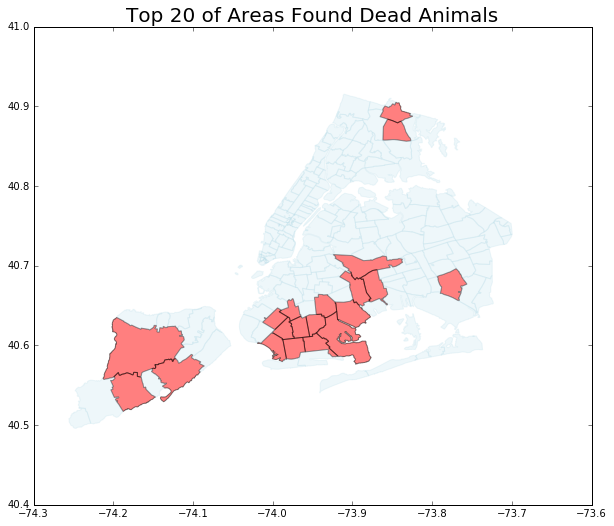

In [6]:
ziplist = ['11234', '11230', '10314', '11223', '11219', '11229', '11210','11204', '11236', '11214','11218','10306','10469','10466','10312','11203','11434','11207','11208','11385']

nyc_zip = []
biz_zip = set()
for department in data['features']:
    nyc_zip.append(str(department['properties']["postalCode"]))
    
new_zip = set(ziplist).intersection(set(nyc_zip))
biz_zip = biz_zip.union(new_zip)

biz_zip = sorted(biz_zip)


fig = plt.figure(figsize=(10,10))
for i in data['features']:
    poly = i['geometry']
    postcode = str(i['properties']['postalCode'])
    ax = fig.gca()
    if postcode in list(biz_zip):
        ind = list(biz_zip).index(postcode)
        ax.add_patch(PolygonPatch(poly, fc='r', ec= 'k' , alpha=0.5, zorder=1))
    else:
        ax.add_patch(PolygonPatch(poly, fc='lightblue', ec='lightblue', alpha=0.2, zorder=2 ))
ax.axis('scaled')
plt.title('Top 20 of Areas Found Dead Animals', size=20)

In [7]:
weather = pd.read_csv('1209_1511.csv')
weather['EDT'] = pd.to_datetime(weather['EDT'])
# for i in range(len(weather)):
#     weather['EDT'][i] = weather['EDT'][i].date()
weather = weather.dropna()

In [8]:
weather = weather[['EDT','Max TemperatureF','Min TemperatureF','Max Humidity',' Min Humidity',' Max Wind SpeedMPH',' Events',' WindDirDegrees']]

In [9]:
dz = df.groupby(['Incident Zip','Created Date']).count()
del dz['Descriptor']
del dz['Longitude']
del dz['Latitude']
dz.columns = ['Count']
dz = dz.sort('Count',ascending=False)

/Users/Faye/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [10]:
dz = dz.reset_index()

In [11]:
dz.head()

,Incident Zip,Created Date,Count
0,11234,2014-04-27,43
1,10029,2015-08-23,24
2,10457,2012-03-04,24
3,11221,2014-10-25,24
4,11210,2015-08-16,24


In [12]:
dv = df.groupby(['Created Date']).count()

dv = dv.reset_index()
del dv['Borough']
del dv['Latitude']
del dv['Longitude']

del dv['Incident Zip']

In [13]:
# weather.head(1)

In [14]:
dv['Created Date'] = pd.to_datetime(dv['Created Date'])

In [15]:
dv['EDT'] = dv['Created Date']
result_311 = pd.merge( dv, weather, how='inner', on=['EDT'], indicator=True)
# del result_311['Unnamed: 0']
del result_311['Created Date']

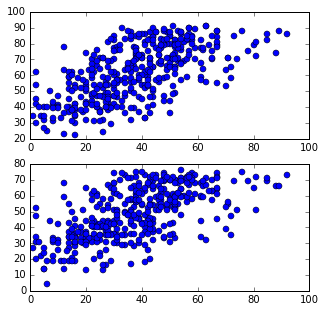

In [16]:
plt.subplot(2, 1, 1)
plt.plot(result_311['Descriptor'],result_311['Max TemperatureF'] ,'o')

plt.subplot(2, 1, 2)
plt.plot(result_311['Descriptor'],result_311['Min TemperatureF'] ,'o')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.399
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                     129.2
Date:                Wed, 16 Dec 2015   Prob (F-statistic):           8.82e-44
Time:                        07:20:50   Log-Likelihood:                -1589.7
No. Observations:                 393   AIC:                             3185.
Df Residuals:                     390   BIC:                             3197.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -6.0537      8.615     -0.703      0.4

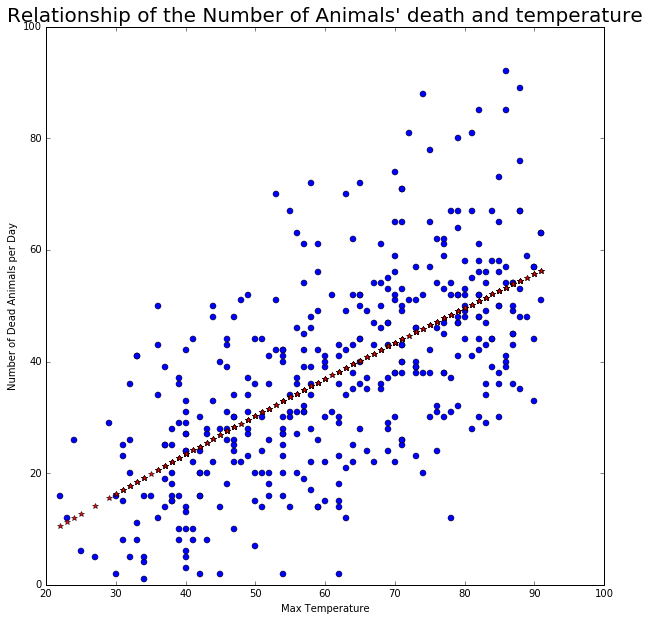

In [24]:
result_311['y']=result_311['Descriptor']
result_311['x']=result_311['Max TemperatureF']
result_311['x2']=pow(result_311['Max TemperatureF'],2)
lm2 = smf.ols(formula='y ~ x+x2', data = result_311).fit()
print(lm2.summary())
fig = plt.figure(figsize=(10,10))
lmy2 = lm2.predict(result_311)
plt.plot(result_311['x'],result_311.y,'ob')
plt.plot(result_311.x,lmy2,'*r') 
plt.title("Relationship of the Number of Animals' death and temperature", size =20)
plt.xlabel('Max Temperature')
plt.ylabel('Number of Dead Animals per Day')